In [1]:
import pandas as pd
import ast
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data Preprocessing
full_data = pd.read_csv('/kaggle/input/moviesummaries/FinalMovieData.tsv', delimiter='\t')
import dateutil.parser
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def parse_date(date):
    if isinstance(date, str):
        try:
            parsed_date = dateutil.parser.parse(date)
            return pd.Timestamp(parsed_date.year, parsed_date.month, parsed_date.day)
        except Exception as e:
            print(f"Error parsing date '{date}': {e}")
            parts = date.split('-')
            if len(parts) == 2:
                try:
                    return pd.Timestamp(int(parts[0]), int(parts[1]), 1)
                except Exception as e:
                    print(f"Error parsing date '{date}': {e}")
                    return None
            else:
                try:
                    return pd.Timestamp(int(parts[0]), 1, 1)
                except Exception as e:
                    print(f"Error parsing date '{date}': {e}")
                    return None
    else:
        return None

    
# Then apply this function as before and see the printed output.
full_data['Date'] = full_data['Date'].apply(parse_date)

# Drop rows with None in 'Date'
full_data = full_data.dropna(subset=['Date'])

full_data = full_data[full_data['Date'].apply(lambda x: x.year >= 2000)]

# Drop rows with missing 'Country' values
full_data = full_data.dropna(subset=['Country'])

# Convert 'Country' column to dict
full_data['Country'] = full_data['Country'].apply(ast.literal_eval)

# Filter out movies that weren't made in the United States
full_data = full_data[full_data['Country'].apply(lambda x: 'United States of America' in x.values())]

summaries_small = full_data['Plot Summary'].reset_index(drop=True)
titles_small = full_data['Title'].reset_index(drop=True)
ids_small = full_data['ID'].reset_index(drop=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(summaries_small.shape)

Error parsing date '1010-12-02': Out of bounds nanosecond timestamp: 1010-12-02 00:00:00
Error parsing date '1010-12-02': Out of bounds nanosecond timestamp: 1010-01-01 00:00:00
(6700,)


In [3]:
# skip-gram on Google News data
from nltk.data import find
import gensim
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

# now we can find embedding of each word with model[<word>]

# expects a list of summaries
def tokenize_and_embed_data(raw_data):
    data = []
    for summary in raw_data:
        summ = []
        for sentence in sent_tokenize(summary):
            sent = []
            for word in word_tokenize(sentence):
                word = str.lower(word)
                if word in model:
                    embedding = model[word]
                    sent.append(embedding)
            if sent:
                avg_sent_embed = np.mean(sent, axis=0)
                summ.append(avg_sent_embed)
        if summ:
            avg_summ_embed = np.mean(summ, axis=0)
            data.append(avg_summ_embed)
    return data

# tokenize and embed data
processed_data = tokenize_and_embed_data(summaries_small)

In [4]:
from sklearn.cluster import SpectralClustering

number_of_clusters = 1000
# Perform clustering with Spectral
clustering = SpectralClustering(n_clusters=number_of_clusters, assign_labels='discretize',random_state=7).fit(processed_data)

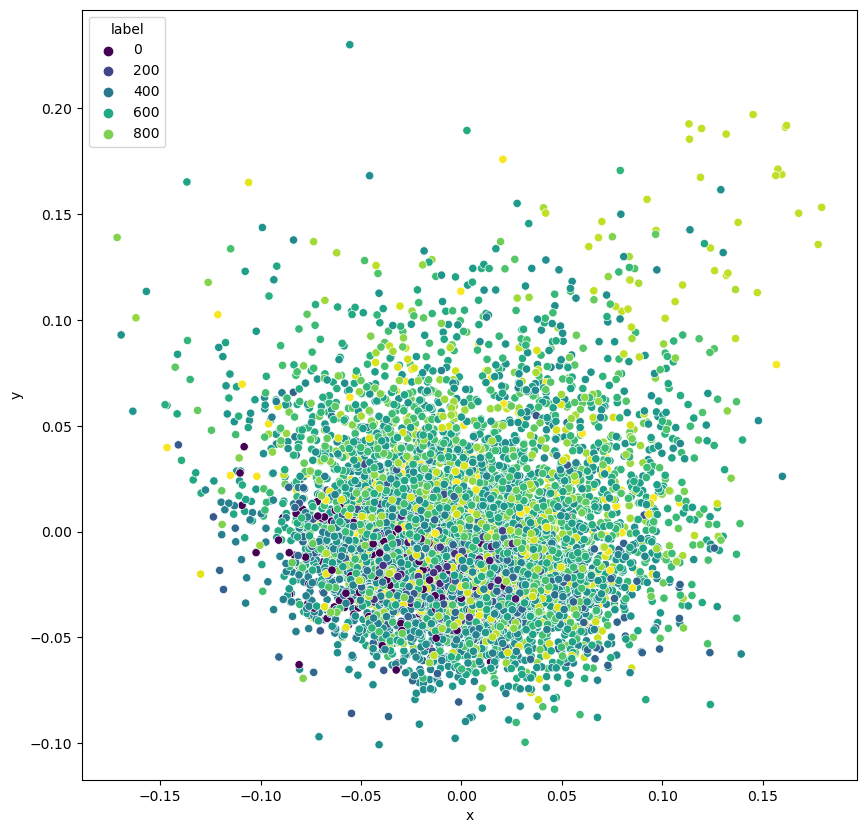

Cluster 0 summaries:
         ID       Title                                            Summary
255  146947  Spider-Man  High-school senior Peter Parker  lives in Fore...


Cluster 1 summaries:
            ID                                              Title                                            Summary
2       156558                                           Baby Boy  A young 20-year-old named Jody  lives with his...
65     1612686                             Halloween Resurrection  Three years after the events that happened in ...
185   19787914                                           Scream 4  On the fifteenth anniversary of the original W...
294    8620409                                      The Dead Girl  The movie is presented in five segments, each ...
356    7681320                                     Turn the River  Turn the River stars Famke Janssen as Kailey S...
373   34044006                                           Excision  The film depicts the life of a distur

In [5]:
# PCA for dimension reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_data)

# Create a DataFrame for easy plotting
df = pd.DataFrame(reduced_data, columns=['x', 'y'])
df['label'] = clustering.labels_
df['Title'] = titles_small
df['Summary'] = summaries_small
df['ID'] = ids_small

# print(df)

# Plot using seaborn
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='viridis', legend=True)
plt.show()

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50)

# Print out summaries from each cluster
for i in range(number_of_clusters):  # Change this range depending on which clusters you want to look at
    print(f'Cluster {i} summaries:')
    print(df[df['label'] == i][['ID', 'Title', 'Summary']])
    print('\n')

In [6]:
cluster_counts = df['label'].value_counts()
largest_cluster = cluster_counts.idxmax()
largest_cluster_size = cluster_counts.max()

print(f"The largest cluster is: {largest_cluster} with size: {largest_cluster_size}")

The largest cluster is: 1 with size: 148
